##  CIFAR10 Dataset

CIFAR10 dataset bao gồm 60000 ảnh màu 32x32 pixels được chia thành 10 class. Một vài ví dụ từ dataset:

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">


In [57]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

Tải và giải nén dataset

In [58]:
# Dowload the dataset
!wget -cq https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

Dataset được giải nén đến  `data/cifar10`. Nó bao gồm 2 folders `train` and `test`, tập train bao gồm 50000 ảnh và tập test bao gồm 10000 ảnh. Ta dùng `os.listdir` để mở.

In [59]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['bird', 'cat', 'dog', 'automobile', 'horse', 'frog', 'ship', 'deer', 'airplane', 'truck']


Xem thử một vài file trong tập train và test:

In [60]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['1362.png', '4135.png', '0906.png', '3360.png', '1774.png']


In [61]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0906.png', '0792.png', '0553.png', '0478.png', '0525.png']


Ta cần chuyển dataset về các tensor để thực hiện cho việc xử lý:

In [62]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [63]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [64]:
len(dataset)

50000

Mỗi phần tử trong tập dataset bao gồm tensor của ảnh và label(nhãn). Dữ liệu là ảnh màu với 3 channels (RGB), mỗi tensor của ảnh có shape `(3, 32, 32)`.

Các class của dataset:

In [65]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Ta có thể xem ảnh bằng `matplotlib`, nhưng khi dùng câu lệnh transform=ToTensor() thì tensor của ảnh là `(32,32,3)`. Ta cần dùng hàm .permute để chuyển vị trí các phần tử trong tensor thành `(3,32,32)`

In [66]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [67]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Xem qua 1 vài ảnh trong dataset:

Label:  airplane (0)


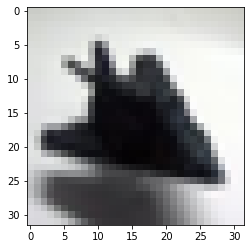

In [68]:
show_example(*dataset[0])

Label:  airplane (0)


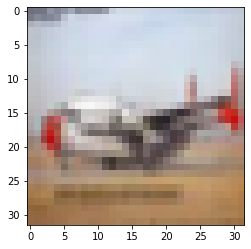

In [69]:
show_example(*dataset[1099])

## Training and Validation Datasets

Ta chia dataset thành 3 phần:

1. **Training set** - dùng để train the model: tính toán loss và điều chỉnh weights của model với gradient descent.
2. **Validation set** - dùng để đánh giá model trong lúc train, điều chỉnh learning rate và chọn version tốt nhất của model.
3. **Test set** - dùng để so sánh các model và báo cáo accuracy của model.

Chúng ta đã có tập test rồi nên chỉ cần chia tập train thành 2 tập: train_ds và val_ds. Ta dùng hàm `(random_split)` trong Pytorch để chia một cách ngẫu nhiên nhất

In [70]:
random_seed = 42
torch.manual_seed(random_seed);

In [71]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

Tạo các data loader cho train và xác minh(validation) để tải lên data trong các batch

In [72]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [73]:
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)
val_dl = DataLoader(val_ds, 
                    batch_size*2, 
                    num_workers=4, 
                    pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Vì ta đặt `(shuffle=True)` nên dữ liệu trong các batch sẽ được chọn ngẫu nhiên. Mỗi lần chạy ta sẽ được các batch khác nhau.

Thử xem trong 1 batch có gì:

In [74]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


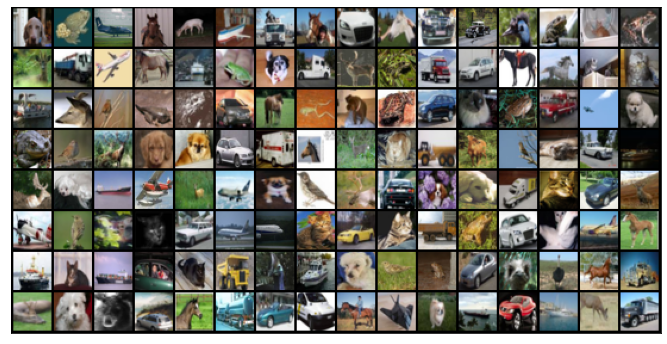

In [75]:
show_batch(train_dl)

## Định nghĩa Model (Convolutional Neural Network)

Phép tính Convolution:

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">



In [76]:
import torch.nn as nn
import torch.nn.functional as F

Sử dụng nn.Sequential để tạo các layer 

In [77]:
simple_model = nn.Sequential( 
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), ##Tạo convolution layer
    nn.MaxPool2d(2, 2) ##Tạo pooling layer
)

In [78]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


Định nghĩa model: xây dựng lớp `ImageClassificationBase` bao gồm các phương thức giúp train và kiểm tra:


In [79]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


Dùng `nn.Sequential` để ghép các layer thành một cấu trúc network.

In [80]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            ##input: 3 x 32 x 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            ##output: 32 x 32 x 32
            nn.ReLU(), ## xem các phần tử, phần tử nào âm thì thay bằng 0
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [81]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [82]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0227,  0.0050,  0.0075, -0.0167,  0.0360, -0.0371, -0.0080, -0.0307,
        -0.0291,  0.0121], grad_fn=<SelectBackward>)


Để dễ dàng và nhanh chóng trong việc train model, chúng ta cần chuyển dữ liệu lên GPU để làm việc. Xây dựng lớp `DeviceDataLoader`:


In [83]:
def get_default_device(): #xem thiết bị mặc định
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device): 
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Xem thiết bị trên máy:

In [84]:
device = get_default_device()
device

device(type='cuda')

Chuyển dữ liệu vào GPU:


In [85]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Train  Model

Định nghĩa hàm: `fit` and `evaluate` để train model với gradient descent và đánh giá hiệu suất trên tập validation. 

In [86]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Trước khi train, xem Accuracy hiện tại:

In [87]:
model = to_device(Cifar10CnnModel(), device)

In [88]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.10143611580133438, 'val_loss': 2.3031394481658936}

Accuracy khoảng 10%


Ta xây dựng learning rate, số epoch,... để train model


In [89]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.001

In [90]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.8031, val_loss: 1.5172, val_acc: 0.4297
Epoch [1], train_loss: 1.2847, val_loss: 1.1094, val_acc: 0.5961
Epoch [2], train_loss: 1.0145, val_loss: 0.9329, val_acc: 0.6700
Epoch [3], train_loss: 0.8367, val_loss: 0.8534, val_acc: 0.6979
Epoch [4], train_loss: 0.7049, val_loss: 0.7625, val_acc: 0.7364
Epoch [5], train_loss: 0.6070, val_loss: 0.7368, val_acc: 0.7491
Epoch [6], train_loss: 0.5151, val_loss: 0.6818, val_acc: 0.7694
Epoch [7], train_loss: 0.4393, val_loss: 0.7591, val_acc: 0.7586
Epoch [8], train_loss: 0.3661, val_loss: 0.7151, val_acc: 0.7724
Epoch [9], train_loss: 0.3083, val_loss: 0.7824, val_acc: 0.7699
Epoch [10], train_loss: 0.2420, val_loss: 0.9496, val_acc: 0.7550
Epoch [11], train_loss: 0.2005, val_loss: 0.8367, val_acc: 0.7814
Epoch [12], train_loss: 0.1723, val_loss: 1.0873, val_acc: 0.7478
Epoch [13], train_loss: 0.1418, val_loss: 1.0118, val_acc: 0.7744
Epoch [14], train_loss: 0.1235, val_loss: 1.0747, val_acc: 0.7708
Epoch [15], train_lo

Vẽ đồ thị biểu diễn Accuracy qua từng lần train:

In [91]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

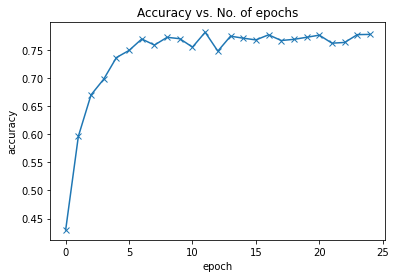

In [92]:
plot_accuracies(history)

Model đạt được accuracy khoảng tầm 75% và khó có thể đạt được accuracy cao hơn sau khi train thêm nhiều lần

Như vậy ta thấy cần dùng các model mạnh hơn để biết được mối quan hệ gữa ảnh và label chính xác hơn.

Xây dựng biểu đồ giữa loss qua các lần train:

In [93]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

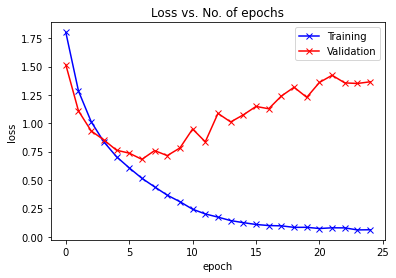

In [94]:
plot_losses(history)

## Test với các hình ảnh:

Tạo tập test_dataset:



In [95]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Xây dựng hàm `predict_image`trả về nhãn dự đoán cho 1 tensor.

In [96]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: automobile , Predicted: automobile


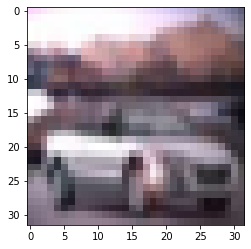

In [97]:
img, label = test_dataset[1230]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: bird , Predicted: bird


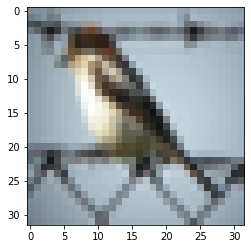

In [103]:
img, label = test_dataset[2556]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


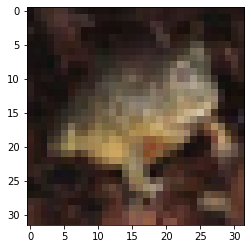

In [99]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

## Tải lên file ảnh dog.png và dự đoán

In [100]:
new_test = ImageFolder('./data/New_test', transform=ToTensor())
len(new_test)

1

 Predicted: dog


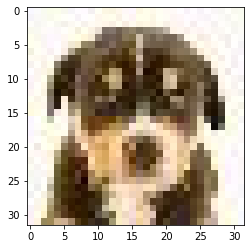

In [101]:
img, label = new_test[0]
plt.imshow(img.permute(1, 2, 0))
print( ' Predicted:', predict_image(img, model))

Xem kết quả cuối cùng sau khi train:

In [102]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7850586175918579, 'val_loss': 1.3335239887237549}